In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.PCA import PCA, PCA_Projected_data, Test_PCA

In [2]:
df = pd.read_json("../Data/data_frame.json", orient='records', lines=True)
D = np.stack(df['image_vector'].values)
y = df['label'].values 

X_train = D[: : 2]
X_test = D[1: : 2]

y_train = y[: : 2]
y_test = y[1: : 2]

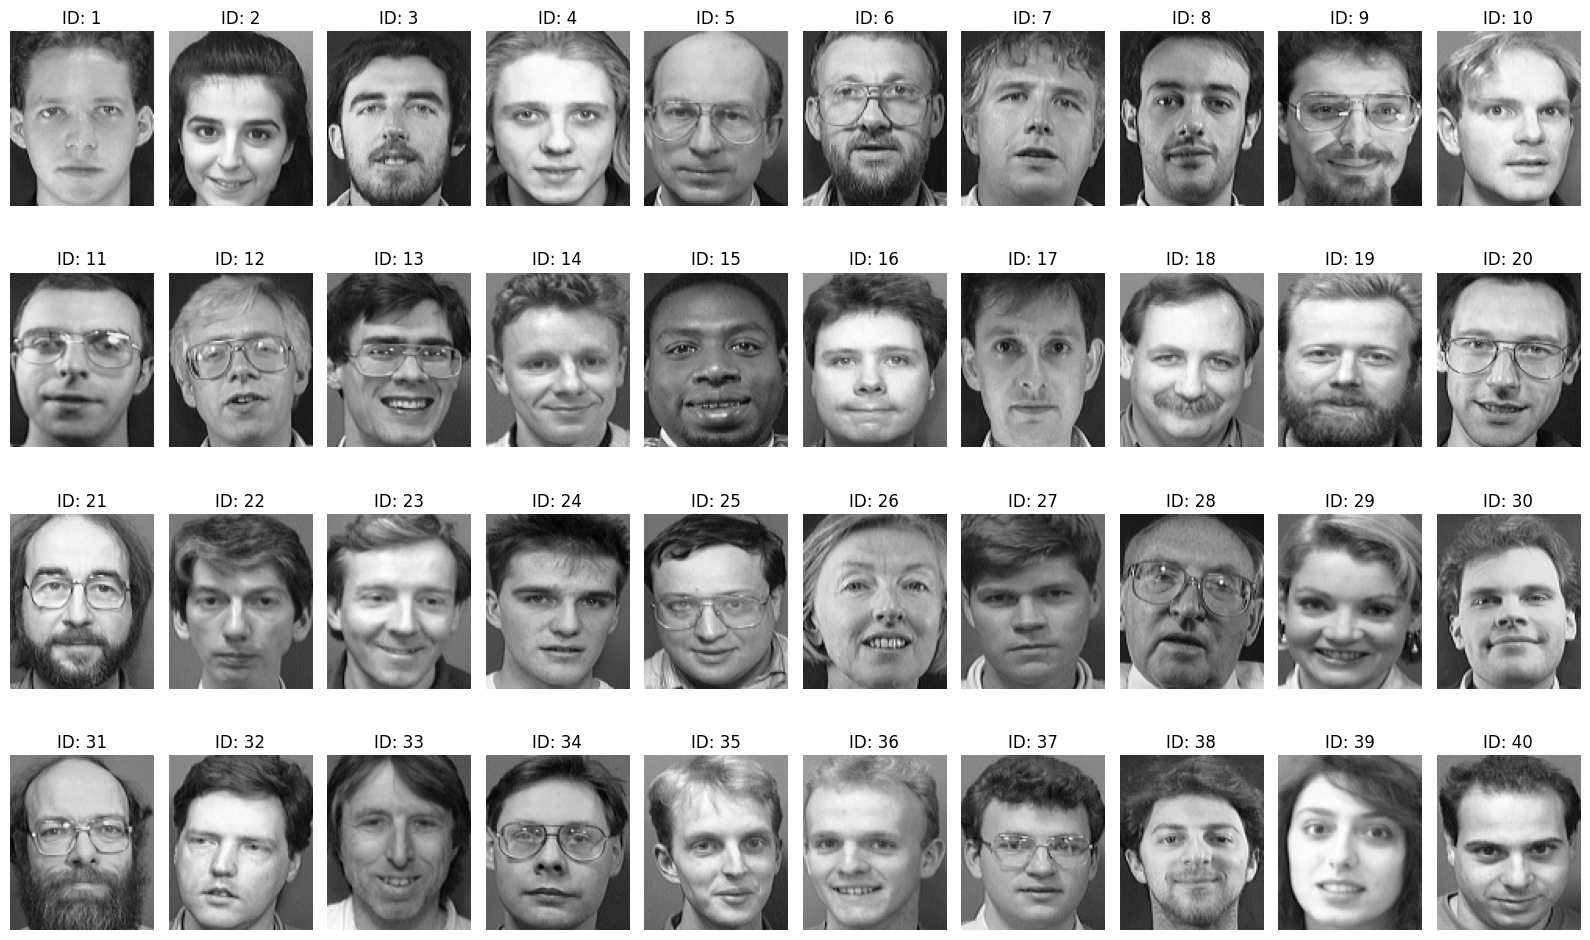

In [3]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(4, 10, figsize=(16, 10))
axs = axs.ravel()

for i in range(40):
    image_vector = df.iloc[i * 10]["image_vector"]  
    image_array = np.reshape(image_vector, (image_height, image_width))
    
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title(f"ID: {i + 1}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [4]:
mean_face, eigenfaces = PCA(X_train, 0.8)
eigenfaces.shape

(10304, 36)

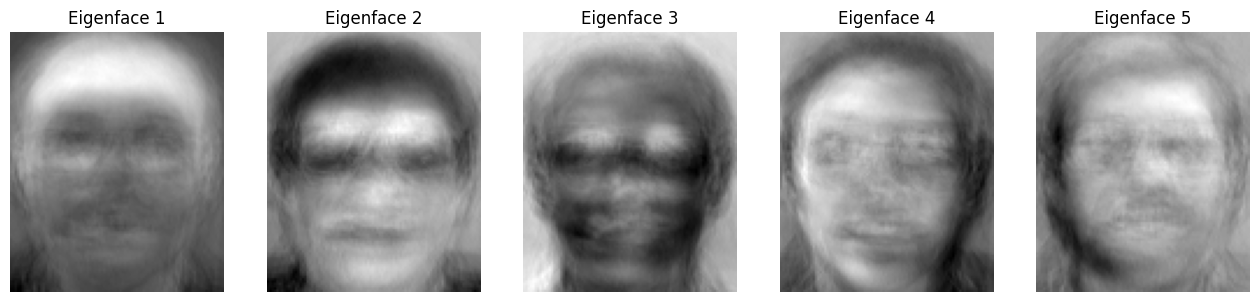

In [5]:
# plotting first 5 eigenfaces
_, eigenfaces = PCA(X_train, 0.95)

image_height = 112
image_width = 92
fig, axs = plt.subplots(1, 5, figsize=(16, 10))
for i in range(5):
    image_array = np.reshape(eigenfaces[:, i], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title("Eigenface " + str(i + 1))
    axs[i].axis("off")

In [6]:
print("PCA Accuracy: " + str(Test_PCA(X_train,X_test,y_train,y_test,0.85, 1)))

PCA Accuracy: 0.94


In [7]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
df = pd.DataFrame(index=alphas, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        accuracy = Test_PCA(X_train,X_test,y_train,y_test,num_dominant_eigen_vectors, k)
        df.loc[num_dominant_eigen_vectors, k] = accuracy

df

,1,3,5,7,9
0.80,0.94,0.905,0.895,0.88,0.835
0.85,0.94,0.9,0.895,0.855,0.83
0.90,0.94,0.905,0.89,0.855,0.815
0.95,0.93,0.9,0.865,0.83,0.805


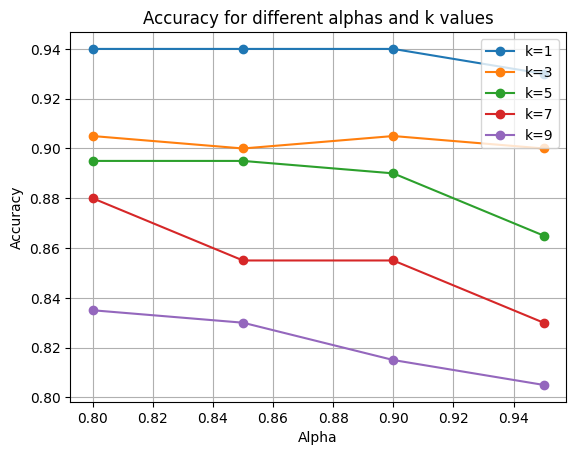

In [8]:
for k in k_values:
    plt.plot(df.index, df[k], marker="o", label=f"k={k}")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy for different alphas and k values")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

###  Compare vs Non-Face Images

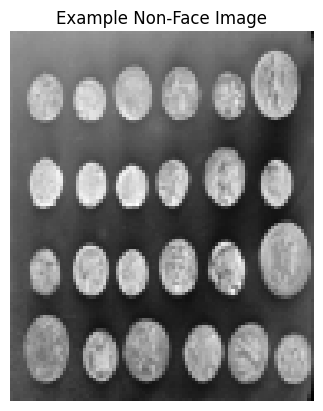

In [9]:
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

non_face_images = [  
    data.coins(),        
    data.moon(),        
    data.page(),       
    data.clock()
]

non_face_data = []

for i, img in enumerate(non_face_images):
    if img.ndim == 3:  
        img = rgb2gray(img)
    img_resized = resize(img, (112, 92), anti_aliasing=True)
    img_vector = (img_resized * 255).astype(np.uint8).ravel()
    non_face_data.append({'image_vector': img_vector, 'label': 'non_face'})

non_face_df = pd.DataFrame(non_face_data)

plt.imshow(non_face_data[0]['image_vector'].reshape(112, 92), cmap='gray')
plt.title("Example Non-Face Image")
plt.axis('off')
plt.show()


In [10]:
face_data = pd.read_json("../Data/data_frame.json", orient='records', lines=True)
face_data['label'] = 'face'

combined_df = pd.concat([face_data, non_face_df], ignore_index=True)

X = np.stack(combined_df['image_vector'].values)
y = combined_df['label'].values


In [11]:
print(len(face_data))
print(len(face_data['label']))

400
400


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_lda, y_train)

y_pred = model.predict(X_test_lda)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9918032786885246
              precision    recall  f1-score   support

        face       0.99      1.00      1.00       121
    non_face       0.00      0.00      0.00         1

    accuracy                           0.99       122
   macro avg       0.50      0.50      0.50       122
weighted avg       0.98      0.99      0.99       122



c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Number of misclassified images: 1
Number of correctly classified images: 121


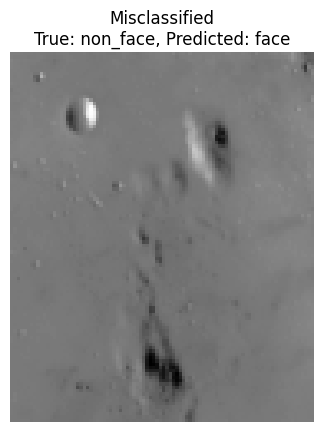

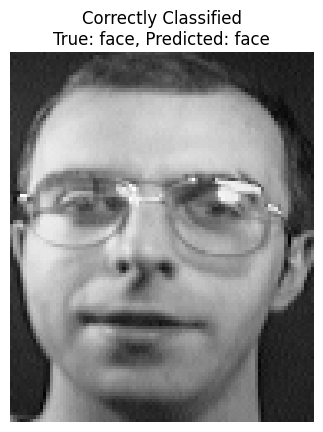

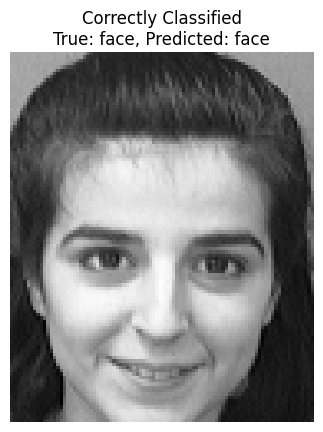

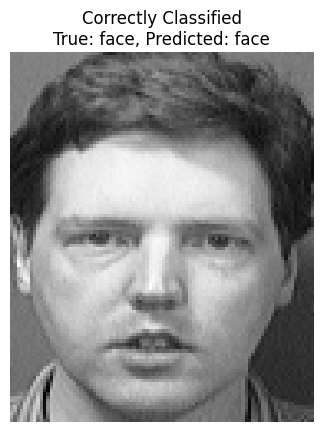

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Identify misclassified and correctly classified indices
wrong_indexes = np.where(y_pred != y_test)[0]
correct_indexes = np.where(y_pred == y_test)[0]

# Show number of success and failure cases
print(f"Number of misclassified images: {len(wrong_indexes)}")
print(f"Number of correctly classified images: {len(correct_indexes)}")

# Display up to 3 misclassified images
num_errors = min(3, len(wrong_indexes))
for i in range(num_errors):
    idx = wrong_indexes[i]
    image = X_test[idx].reshape(112, 92)
    plt.imshow(image, cmap='gray')
    plt.title(f"Misclassified\nTrue: {y_test[idx]}, Predicted: {y_pred[idx]}")
    plt.axis('off')
    plt.show()

# Display up to 3 correctly classified images
num_success = min(3, len(correct_indexes))
for i in range(num_success):
    idx = correct_indexes[i]
    image = X_test[idx].reshape(112, 92)
    plt.imshow(image, cmap='gray')
    plt.title(f"Correctly Classified\nTrue: {y_test[idx]}, Predicted: {y_pred[idx]}")
    plt.axis('off')
    plt.show()


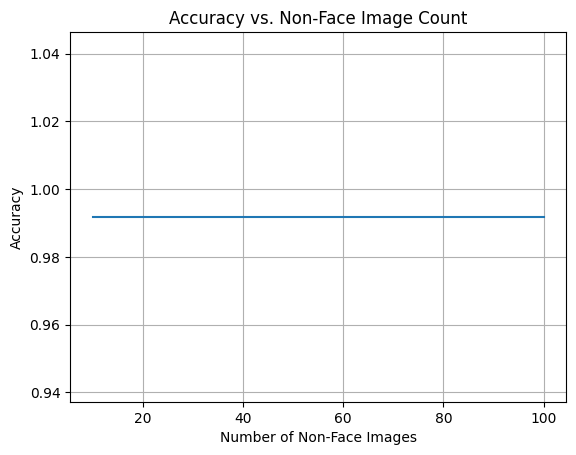

In [15]:
non_face_counts = [10, 30, 50, 100]
accuracies = []

for count in non_face_counts:
    sampled_non_faces = non_face_df.sample(n=count, random_state=42, replace=True)
    sampled_faces = face_data.sample(n=count, random_state=42)

    temp_df = pd.concat([sampled_faces, sampled_non_faces], ignore_index=True)
    X = np.stack(temp_df['image_vector'].values)
    y = temp_df['label'].values
    
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(non_face_counts, accuracies)
plt.xlabel("Number of Non-Face Images")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Non-Face Image Count")
plt.grid(True)
plt.show()


In [ ]:
X_train = []
X_test = []
y_train = []
y_test = []

for i in range(0, len(X), 10):
    X_train.extend(X[i:i+7])
    X_test.extend(X[i+7:i+10])
    y_train.extend(y[i:i+7])
    y_test.extend(y[i+7:i+10])

print(len(X_train), len(y_train)) 
print(len(X_test), len(y_test))   

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


140 140
60 60
(140, 10304) (140,)
(60, 10304) (60,)


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = KNeighborsClassifier(n_neighbors=3)
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"y_train shape: {y_train.shape}")
model.fit(X_train_pca, y_train)
y_pred_pca = model.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)
print("PCA Accuracy (7/3 split):", acc_pca)

X_train_pca shape: (140, 37)
y_train shape: (140,)
PCA Accuracy (7/3 split): 0.9833333333333333


In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_lda, y_train)
y_pred_lda = model.predict(X_test_lda)
acc_lda = accuracy_score(y_test, y_pred_lda)
print("LDA Accuracy (7/3 split):", acc_lda)


LDA Accuracy (7/3 split): 1.0
